In [1]:
import os
import ast
import re
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import constants

In [2]:
def summarize(path, fname):
    model_meta = pd.read_parquet(os.path.join(path, fname))
    def replace(x):
        try:
            return ast.literal_eval(x)
        except:
            return x
    for col in ['train_loss', 'train_acc', 'valid_loss', 'valid_acc']:
        try:
            model_meta[col] = model_meta[col].apply(replace)
        except:
            pass

    model_meta['epochs'] = model_meta['train_loss'].apply(len)
    model_meta['final_train_loss'] = model_meta['train_loss'].apply(lambda x: x[-1])
    model_meta['final_valid_acc'] = model_meta['valid_acc'].apply(lambda x: x[-1])
    model_meta['final_valid_loss'] = model_meta['valid_loss'].apply(lambda x: x[-1])
    model_meta['best_valid_loss'] = model_meta['valid_loss'].apply(min)
    model_meta['best_valid_loss_epoch'] = model_meta['valid_loss'].apply(lambda x: len(x[:np.argmin(x)]))

    return model_meta

In [13]:
model_meta = pd.DataFrame()

root_dir = os.path.join(constants.FINE_TUNING_RESULTS_DIR,
                        'resnet50',
                        'frozen',
                        'fixed_batch_size',
                        '66_33_split')
base_dir = os.path.join(constants.FINE_TUNING_RESULTS_DIR,
                        'resnet50',
                        'baseline',
                        'fixed_batch_size',
                        '80_20_split')
source_train_baseline_dir = os.path.join(base_dir, 'baseline_s_20k_t_20')
exp_dir = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

for f in os.listdir(source_train_baseline_dir):
    if f.endswith('.parquet') and f.startswith('source'):
        trial_results = summarize(os.path.join(root_dir, source_train_baseline_dir), f)
        phase, _, iter_idx, _ = re.split('[_.]', f)
        trial_results.loc[:, 'phase'] = phase
        trial_results.loc[:, 'iter_idx'] = iter_idx

        try:
            with open(os.path.join(root_dir, source_train_baseline_dir, f'args_{iter_idx}.json')) as arg_f:
                args = json.load(arg_f)
        except OSError:
            print('No corresponding args.json file associated with trial!')

        for key in ['num_source_epochs', 'num_target_epochs', 'source_lr', 'target_lr', 'source_batch_size', 'target_batch_size',
                    'train_seed', 'hidden_size', 'data_sampler_seed', 'n_source_samples', 'n_target_samples']:
            trial_results.loc[:, key] = args[key]

        model_meta  = model_meta.append(trial_results, ignore_index=True)
    
for d in exp_dir:
    for f in os.listdir(os.path.join(root_dir, d)):
        if (f.endswith('.parquet')) and ('target' in f):
            trial_results = summarize(os.path.join(root_dir, d), f)
            phase, _, iter_idx, _ = re.split('[_.]', f)
            trial_results.loc[:, 'phase'] = phase
            trial_results.loc[:, 'iter_idx'] = iter_idx

            try:
                with open(os.path.join(root_dir, d, f'args_{iter_idx}.json')) as arg_f:
                    args = json.load(arg_f)
            except OSError:
                print('No corresponding args.json file associated with trial!')

            for key in ['num_source_epochs', 'num_target_epochs', 'source_lr', 'target_lr', 'source_batch_size', 'target_batch_size',
                        'train_seed', 'hidden_size', 'data_sampler_seed', 'n_source_samples', 'n_target_samples']:
                trial_results.loc[:, key] = args[key]

            model_meta = model_meta.append(trial_results, ignore_index=True)
        

In [14]:
source_meta = model_meta[model_meta['phase'] == 'source']

performance_cols = ['mimic_test_loss', 'mimic_test_acc', 'mimic_test_auc',
                    'chexpert_test_loss', 'chexpert_test_acc', 'chexpert_test_auc']

In [15]:
source_meta.mean()[performance_cols]

mimic_test_loss       0.610307
mimic_test_acc        0.779560
mimic_test_auc        0.851603
chexpert_test_loss    0.574381
chexpert_test_acc     0.845750
chexpert_test_auc     0.908530
dtype: float64

In [16]:
target_meta = model_meta[model_meta['phase'] == 'target']

performance_cols = ['mimic_best_test_loss', 'mimic_final_test_loss', 'mimic_best_test_acc', 'mimic_final_test_acc',
                    'chexpert_best_test_loss', 'chexpert_final_test_loss', 'chexpert_best_test_acc', 'chexpert_final_test_acc']

In [17]:
target_meta.groupby('n_target_samples').max(numeric_only=True)[performance_cols]

,mimic_best_test_loss,mimic_final_test_loss,mimic_best_test_acc,mimic_final_test_acc,chexpert_best_test_loss,chexpert_final_test_loss,chexpert_best_test_acc,chexpert_final_test_acc
n_target_samples,,,,,,,,
20,0.612619,0.614511,0.778767,0.762973,0.576560,0.615728,0.842250,0.797375
50,0.616831,0.616782,0.781148,0.777012,0.584392,0.594947,0.840375,0.798625
100,0.615372,0.615670,0.779519,0.769240,0.602578,0.604446,0.814500,0.766625
200,0.618160,0.618068,0.774129,0.774881,0.595418,0.595644,0.771750,0.773125
500,0.616607,0.615889,0.774505,0.774380,0.602295,0.603920,0.773250,0.771500
1000,0.618911,0.618131,0.774254,0.774254,0.597804,0.602736,0.781500,0.768625
2000,0.620368,0.623780,0.773126,0.773251,0.599684,0.600339,0.780750,0.788125
5000,0.620265,0.617723,0.773251,0.774505,0.600012,0.599418,0.786875,0.768125


In [18]:
target_meta.groupby('n_target_samples').mean()[performance_cols]

,mimic_best_test_loss,mimic_final_test_loss,mimic_best_test_acc,mimic_final_test_acc,chexpert_best_test_loss,chexpert_final_test_loss,chexpert_best_test_acc,chexpert_final_test_acc
n_target_samples,,,,,,,,
20,0.610259,0.612518,0.777012,0.747723,0.575510,0.602342,0.835042,0.732375
50,0.612763,0.614958,0.777430,0.771371,0.577981,0.588145,0.824417,0.781833
100,0.611775,0.612006,0.763099,0.757918,0.594306,0.598702,0.758125,0.741708
200,0.615002,0.615427,0.768864,0.768196,0.593761,0.593921,0.761417,0.760792
500,0.614409,0.613704,0.765146,0.764268,0.596837,0.599621,0.750458,0.741458
1000,0.615701,0.615327,0.767945,0.765981,0.594126,0.597063,0.759833,0.751125
2000,0.616048,0.617754,0.767527,0.767068,0.593175,0.592580,0.763417,0.766500
5000,0.616099,0.615123,0.767402,0.769115,0.593431,0.595162,0.762375,0.756458


In [19]:
target_meta.groupby('n_target_samples').std()[performance_cols]

,mimic_best_test_loss,mimic_final_test_loss,mimic_best_test_acc,mimic_final_test_acc,chexpert_best_test_loss,chexpert_final_test_loss,chexpert_best_test_acc,chexpert_final_test_acc
n_target_samples,,,,,,,,
20,0.003696,0.001986,0.001600,0.016851,0.001065,0.016139,0.012485,0.058660
50,0.004280,0.002587,0.003433,0.009232,0.005599,0.005893,0.022843,0.021208
100,0.003116,0.003173,0.017081,0.011604,0.014111,0.007176,0.048831,0.022069
200,0.003965,0.004076,0.005604,0.006836,0.001750,0.002010,0.008971,0.010728
500,0.003143,0.003594,0.009597,0.009343,0.005654,0.007033,0.020507,0.026182
1000,0.004772,0.003253,0.007544,0.011039,0.004651,0.004970,0.018779,0.018509
2000,0.004528,0.005715,0.008948,0.009960,0.005648,0.006761,0.021221,0.025167
5000,0.004933,0.003645,0.008255,0.006989,0.006164,0.003699,0.023564,0.012810


In [20]:
mimic_meta = target_meta.melt(id_vars=['n_target_samples'], value_vars=['mimic_final_test_loss', 'mimic_final_test_acc', 'mimic_final_test_auc'])
chex_meta = target_meta.melt(id_vars=['n_target_samples'], value_vars=['chexpert_final_test_loss', 'chexpert_final_test_acc', 'chexpert_final_test_auc'])

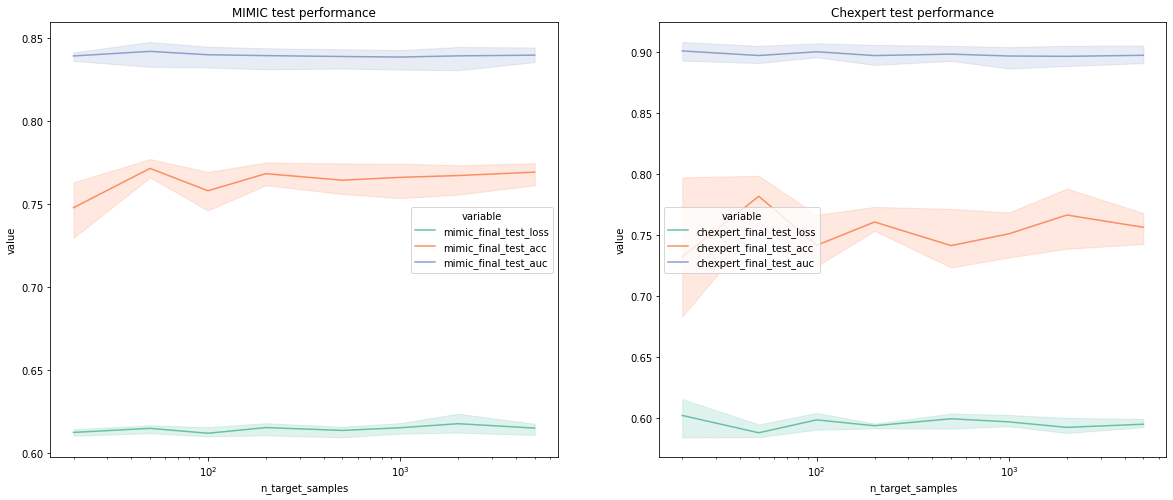

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.lineplot(data=mimic_meta, x='n_target_samples', y='value', hue='variable', palette='Set2', ax=ax[0])
ax[0].set_title('MIMIC test performance')
ax[0].set(xscale='log')
sns.lineplot(data=chex_meta, x='n_target_samples', y='value', hue='variable', palette='Set2', ax=ax[1])
ax[1].set_title('Chexpert test performance')
ax[1].set(xscale='log');